In [1]:
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight

2024-03-18 13:32:39.760565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!wget https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip bamboo.zip
!unzip -P bamboo bamboo.zip

--2024-03-18 13:32:47--  https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28240432 (27M) [application/zip]
Saving to: 'bamboo.zip'

bamboo.zip          100%[===================>]  26.93M  4.19MB/s    in 6.3s    

2024-03-18 13:32:53 (4.25 MB/s) - 'bamboo.zip' saved [28240432/28240432]

--2024-03-18 13:32:53--  http://bamboo.zip/
Resolving bamboo.zip (bamboo.zip)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address 'bamboo.zip'
FINISHED --2024-03-18 13:32:53--
Total wall clock time: 6.7s
Downloaded: 1 files, 27M in 6.3s (4.25 MB/s)
Archive:  bamboo.zip
   creating: bamboo/
   creating: bamboo/test/
  inflating: bamboo/test/test_im

In [3]:
!ls bamboo/train
#image names starting with "b" is image with only bamboo forest.
#image names starting with "o" is image without bamboo forest.

b1.png  b12.png b2.png  b5.png  b8.png  o10.png o4.png  o7.png
b10.png b13.png b3.png  b6.png  b9.png  o2.png  o5.png  o8.png
b11.png b14.png b4.png  b7.png  o1.png  o3.png  o6.png  o9.png


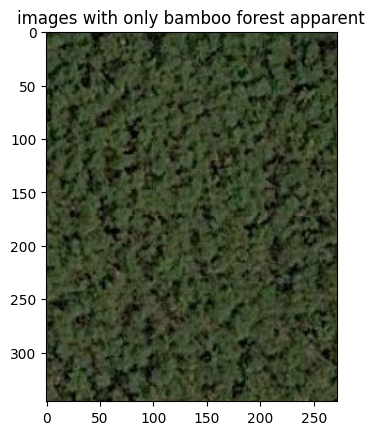

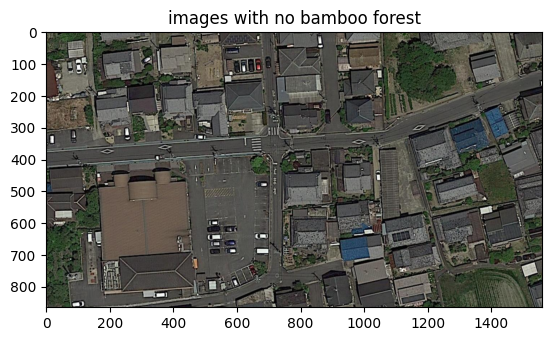

In [4]:
plt.title("images with only bamboo forest apparent")
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


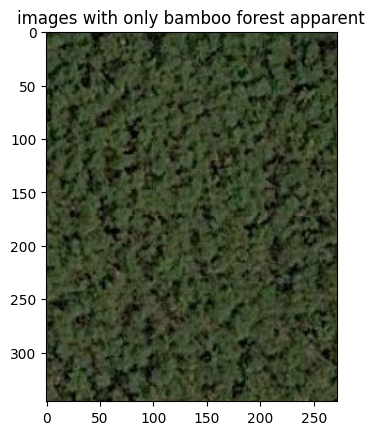

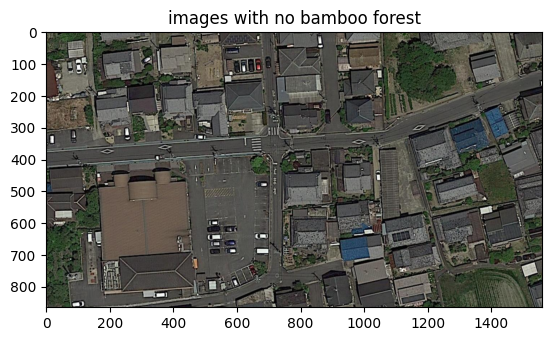

In [5]:
plt.title("images with only bamboo forest apparent")
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


In [6]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("bamboo/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "bamboo/chopped"
    file = os.path.join("bamboo/train/",file)
    save_to_folder(file,save_directory)

In [7]:
files = os.listdir("bamboo/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("bamboo/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(3492, 56, 56, 3) (3492,)


In [8]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(2793, 56, 56, 3)
(2793,)
(699, 56, 56, 3)
(699,)


In [19]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))



cw = compute_class_weight(class_weight = "balanced",classes = np.unique(train_y),y = train_y)
print(cw)

(array([0, 1]), array([ 700, 2093]))
(array([0, 1]), array([175, 524]))
[1.995      0.66722408]


In [10]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

/Users/douglas/tfvenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 56, 56, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,817 (448.50 KB)

 Trainable params: 114,817 (448.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
class_weights = {0: 1.995, 1: 0.66722408}

print ('Train on 2793 samples, validate on 699 samples')

history = model.fit(train_x, train_y, epochs=10,batch_size=1, validation_data=(valid_x, valid_y), class_weight=class_weights)


Train on 2793 samples, validate on 699 samples
Epoch 1/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - acc: 0.7314 - loss: 0.5805 - val_acc: 0.9156 - val_loss: 0.2201
Epoch 2/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - acc: 0.9306 - loss: 0.1968 - val_acc: 0.9628 - val_loss: 0.0864
Epoch 3/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - acc: 0.9483 - loss: 0.1277 - val_acc: 0.9928 - val_loss: 0.0549
Epoch 4/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - acc: 0.9664 - loss: 0.1067 - val_acc: 0.9742 - val_loss: 0.0590
Epoch 5/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - acc: 0.9669 - loss: 0.0873 - val_acc: 0.7496 - val_loss: 0.8878
Epoch 6/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - acc: 0.9706 - loss: 0.0740 - val_acc: 0.9900 - val_loss: 0.0344
Epoch 7/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - acc: 0.9798 - loss: 0.0574 - val_acc: 0.9928 - val_loss: 0.0354
Epoch 8/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - acc: 0.9787 - loss: 0.0506 - val_acc: 0.9

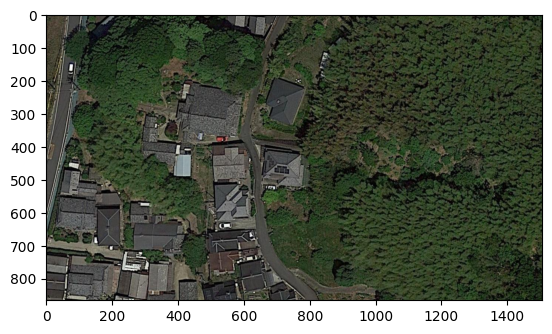

37
2405 37 65


In [13]:
#read test data
img_path = "bamboo/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
(2405, 1)
[[1.08900436e-04]
 [1.18060525e-04]
 [4.96147986e-05]
 ...
 [1.02584250e-02]
 [5.44577837e-02]
 [5.89950942e-02]]


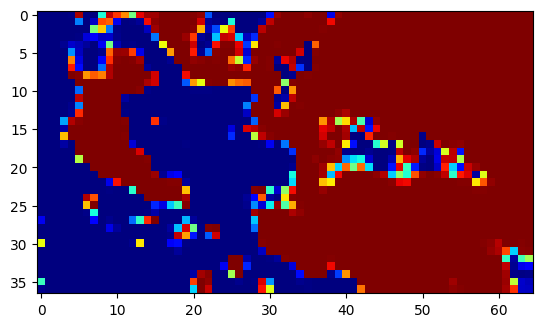

In [14]:
#predict the bamboo probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

bamboo = np.reshape(predictions,(n_total//n_x,n_x))
bamboo = np.rot90(bamboo)
bamboo = np.flip(bamboo,axis=0)
plt.imshow(bamboo,cmap="jet")

In [15]:
h_factor = img.shape[0]//bamboo.shape[0]
w_factor = img.shape[1]//bamboo.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(bamboo,(h_factor,w_factor))

print(zoomed.shape)

23
(851, 1495)


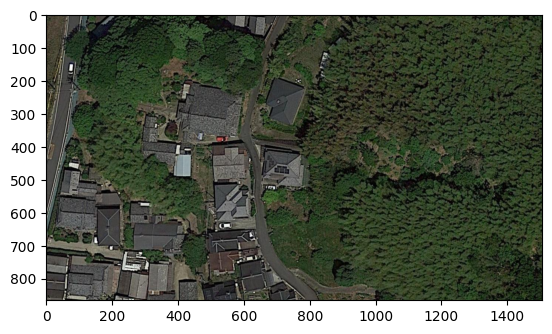

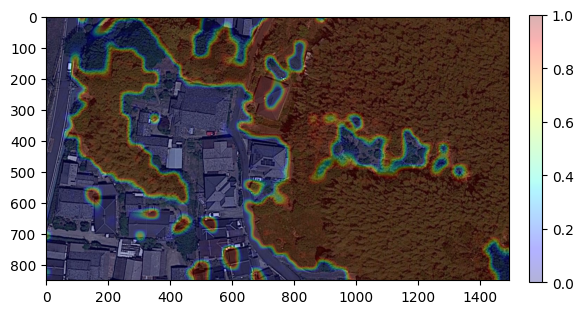

In [16]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

# Question 1

## Model 1 (worst and slowest)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)  # We keep the data augmentation here

    # Entry block
    # Removed the Rescaling layer since we already normalized our data outside of this model
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Adding a few convolutional blocks
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Adding the final layer
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    # Set the correct activation and number of units for CIFAR-10
    activation = "softmax"  # 'softmax' for multi-class classification
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# Adjust `input_shape` for CIFAR-10 images and `num_classes` for 10 classes
model = make_model(input_shape=(32, 32, 3), num_classes=10)
  # Display the model architecture

# Optional: Plot the model (only if you have graphviz installed)
keras.utils.plot_model(model, show_shapes=True)


### Model 2 (most accurate)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, BatchNormalization

# Number of output classes (CIFAR-10 has 10 classes)
n_classes = 10

# Create a sequential model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(input_shape=train_data.shape[1:], filters=96, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

# Second Convolutional Block with Stride to reduce the image spatial size
model.add(Conv2D(filters=96, kernel_size=(3, 3), strides=2, padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Regularization with Dropout

# Third Convolutional Block
model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

# Fourth Convolutional Block with Stride
model.add(Conv2D(filters=192, kernel_size=(3, 3), strides=2, padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Increase dropout for more regularization

# Flattening the volume to feed to the Dense layers
model.add(Flatten())
model.add(BatchNormalization())  # Normalize and scale inputs or activations

# Fully Connected Layers
model.add(Dense(256))  # Dense layer with 256 units
model.add(Activation('relu'))
model.add(Dense(n_classes, activation="softmax"))  # Output layer with softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model's architecture
model.summary()



In [ ]:
n_epochs = 8  # The number of times the model will cycle through the data
batch_size = 256  # The size of the batches of data (number of images) that will be used

# If you have any callbacks, you would initialize them here. For now, we'll keep it as None.
callbacks_list = None

# Start training the model with the CIFAR-10 dataset
H = model.fit(train_data, train_labels,  # Make sure these are your CIFAR-10 training data and labels
              validation_data=(test_data, test_labels),  # And these are your CIFAR-10 testing data and labels
              epochs=n_epochs, 
              batch_size=batch_size, 
              callbacks=callbacks_list)

print('Done!!!')


### Model 3 (fastest)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dropout, Flatten, Dense

# Number of output classes (CIFAR-10 has 10 classes)
n_classes = 10

# Create a sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(input_shape=train_data.shape[1:], filters=32, use_bias=True, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.1))  # Dropout to prevent overfitting

# Second Convolutional Layer with Strides
model.add(Conv2D(filters=64, use_bias=False, kernel_size=(5,5), strides=2))
model.add(Activation('relu'))

# Additional Dropout
model.add(Dropout(0.2))

# Flattening the volume to feed into Dense Layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128))
model.add(Activation('relu'))

# Additional Dropout
model.add(Dropout(0.3))

# Output Layer with Softmax activation for multi-class classification
model.add(Dense(n_classes, activation="softmax"))





  # Display the model architecture

# Optional: Plot the model (only if you have graphviz installed)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
n_epochs = 8  # The number of times the model will cycle through the data
batch_size = 256  # The size of the batches of data (number of images) that will be used

# If you have any callbacks, you would initialize them here. For now, we'll keep it as None.
callbacks_list = None

# Start training the model with the CIFAR-10 dataset
H = model.fit(train_data, train_labels,  # Make sure these are your CIFAR-10 training data and labels
              validation_data=(test_data, test_labels),  # And these are your CIFAR-10 testing data and labels
              epochs=n_epochs, 
              batch_size=batch_size, 
              callbacks=callbacks_list)

print('Done!!!')